# Version 2

Version 1 Gave use very impressive result of `98.3%` accuracy in 5 Epochs. In this version, Instead of changing the architecture I'm going to focus on `Hyperparameter-Tuning`.

In this Part I expect to get a better results as I'll be using techniques that are objectively considered better.

#### Main Focus -
Some of the following tuning don't affect each other, So doing them in parallel will save a lot of time. 
* BatchNorm layer 
* Activation Layer
* Learning Rate

I'll also make changes in the **pipeline** such that **GPU** device can be used if available.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import sys

In [2]:
cuda_available = torch.cuda.is_available()
mps_available = torch.backends.mps.is_available()

device = torch.device("cpu")                # For CPU The Default Device
if cuda_available:
    device = torch.device("cuda:0")
elif mps_available:
    device = torch.device("mps")
    
print("Device:", device)

Device: mps


In [3]:
is_local = True
version = 2

PROJECT_PATH =  pathlib.Path(".") / "MNIST-Digit 8k params"

weights_path = PROJECT_PATH / 'weights/'
model_path = str(weights_path / f'cnn{version}.pt')

## Data

### Load MNIST data

In [4]:
train_data = datasets.MNIST(
    root=PROJECT_PATH, 
    train=True, 
    download=True,
    transform=transforms.ToTensor()
)
test_data = datasets.MNIST(
    root=PROJECT_PATH, 
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

print("Length of train data: ", len(train_data))
print("Length of test data: ", len(test_data))

Length of train data:  60000
Length of test data:  10000


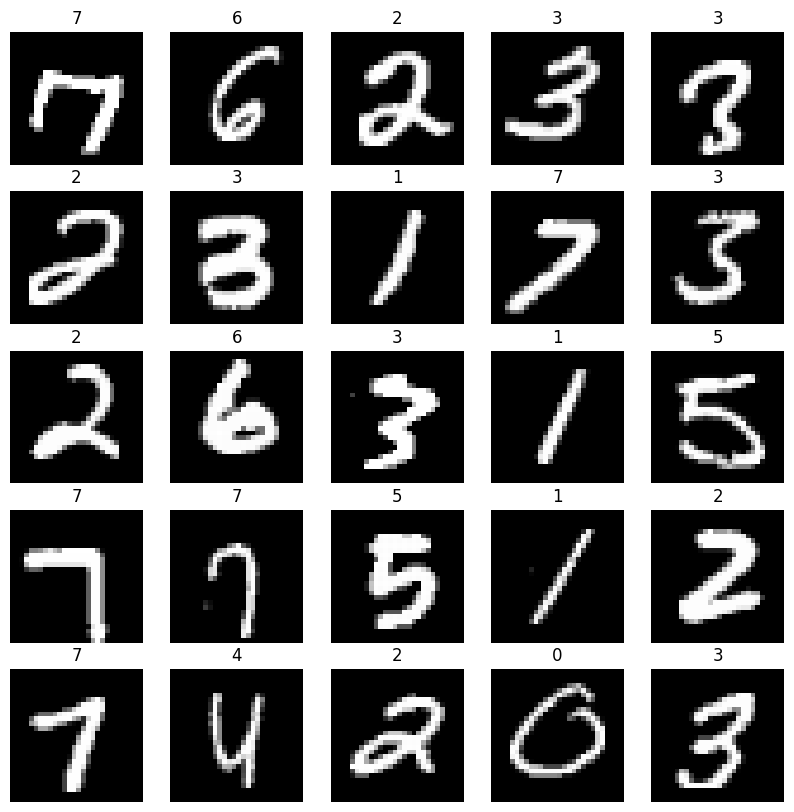

In [5]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader  = DataLoader(test_data,  batch_size=64, shuffle=False)

## MODEL

### Network
For the network The Architecture will remain the same as the previous one, I'm Going to add `BatchNorm`.

#### Main Features 
* BatchNorm layer: So the main change in the network is the addition of `BatchNorm` layer. Using BNL before ACL is a normal pratice,  but let's see how it affects the network otherwise.
* Activation Function: I personally don't think switching to `LReLU` will make a lot of difference, but I'm still going to tryit out as using it with `BatchNorm` may improve network's speed.


In [8]:
class ConvBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int, 
        out_channels: int,
        bn: bool=True,
        bn_ac: bool=True,
        lrelu: bool=True,
    ):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, 1)
        if bn:
            self.bn = nn.BatchNorm2d(out_channels)
        else :
            self.bn = None
        if lrelu:
            self.xrelu = nn.LeakyReLU(0.2)
        else:
            self.xrelu = nn.ReLU()
        
        self.bn_ac = (bn_ac and bn)
        
    def forward(self, x):
        x = self.conv(x)
        if self.bn and self.bn_ac:
            x = self.bn(x)
        x = self.xrelu(x)
        if self.bn and not self.bn_ac:
            x = self.bn(x)
            
        return x
        

class CNN(nn.Module):
    def __init__(
        self, 
        batch_norm: bool=True,   
        bn_ac: bool=True,               # ? (BatchNorm -> Activation) : (Activation -> BatchNorm)
        lrelu: bool=True,
    ):
        super(CNN, self).__init__()
        
        # Block 1
        self.block1 = nn.Sequential(
            ConvBlock(1, 8, batch_norm, bn_ac, lrelu),
            ConvBlock(8, 8, batch_norm, bn_ac, lrelu),
            nn.MaxPool2d(2, 2),
        )
        # Block 2
        self.block2 = nn.Sequential(
            ConvBlock(8, 16, batch_norm, bn_ac, lrelu),
            ConvBlock(16, 32, batch_norm, bn_ac, lrelu),
            nn.MaxPool2d(4, 4),
        )
        self.out = nn.Linear(4*32, 10)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        
        x = x.view(x.size(0), -1) 
        output = self.out(x)
        return output, x 
    
    def summary(self, verbose: int=1, **kwargs):
        """
        Prints the summary of the model.
        """
        summary(
            self,
            input_size=(1, 28, 28),
            batch_dim=0,
            col_names = ("input_size", "output_size", "num_params", "kernel_size"),
            verbose = verbose,
            **kwargs
            )

In [10]:
CNN().summary()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
CNN                                      [1, 1, 28, 28]            [1, 10]                   --                        --
├─Sequential: 1-1                        [1, 1, 28, 28]            [1, 8, 12, 12]            --                        --
│    └─ConvBlock: 2-1                    [1, 1, 28, 28]            [1, 8, 26, 26]            --                        --
│    │    └─Conv2d: 3-1                  [1, 1, 28, 28]            [1, 8, 26, 26]            80                        [3, 3]
│    │    └─BatchNorm2d: 3-2             [1, 8, 26, 26]            [1, 8, 26, 26]            16                        --
│    │    └─LeakyReLU: 3-3               [1, 8, 26, 26]            [1, 8, 26, 26]            --                        --
│    └─ConvBlock: 2-2                    [1, 8, 26, 26]            [1, 8, 24, 24]            --                        --
│    │    

### Training Loop
<!-- I'm going with my useual 1st prefrences
- Adam Optimizer
- Cross Entropy Loss

They often give the best results and are 1st choice for most people. -->

In [11]:
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import copy
import time

def train(
    num_epochs, 
    cnn, 
    train_loader, 
    test_loader, 
    loss_func, 
    optimizer,
    scheduler=None,
):
    
    cnn.train()
    train_stats = {}
    total_step = len(train_loader)
    # loop = tqdm(train_loader, leave=True)
    len_train_loader = len(train_loader)
    for epoch in range(num_epochs):
        # for i, (images, labels) in enumerate(loop):
        print(f"Epoch {epoch+1}/{num_epochs}  (", end="")
        # print(f"    ", end="")
        t = time.time()
        
        for i, (images, labels) in enumerate(train_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            output = cnn(images)[0].to(device)
            
            loss = loss_func(output, labels)
            
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            # loop.set_postfix(loss=loss.item())
            # if (i+1) % (len_train_loader//5) == 0:
            #     print(f"\tStep {i+1}/{total_step}, Training Loss: {loss.item():.4f}")
            if (i+1) % (len_train_loader//40) == 0:
                print(".", end="")
                
        # Model Callbacks
        if scheduler:
            scheduler.step()
            
        #  evaluate
        t = time.time() - t
        step_time = 1000*t/len_train_loader
        print(f") Epoch Time: {t:.2f}s")
        cnn_Copy = copy.deepcopy(cnn)
        train_eval = evaluate(cnn_Copy, train_loader, loss_func, device=device)
        test_eval = evaluate(cnn_Copy, test_loader, loss_func, device=device)
        
        print(f"    Train Loss: {train_eval[0]:.4f}, Train Accuracy: {train_eval[1]:.4f}")
        print(f"    Test Loss:  {test_eval[0]:.4f}, Test Accuracy:  {test_eval[1]:.4f}")
        train_stats[epoch+1] = {
            "train_loss": train_eval[0],
            "train_accuracy": train_eval[1],
            "test_loss": test_eval[0],
            "test_accuracy": test_eval[1],
        }

    return train_stats

def evaluate(network, data_loader, loss_func=None, device="cpu"):
    network.eval()
    loss = 0
    original = []
    predicted = []
    
    if loss_func is None:
        loss_func = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = network(images)[0]
            loss += loss_func(output, labels).item()

            original += labels.to("cpu").tolist()
            predicted += torch.max(output.data, 1)[1].to("cpu").tolist()
    
    accuracy = accuracy_score(original, predicted)
    # f1_score_macro = f1_score(original, predicted, average='macro')
    
    return (loss/len(data_loader)), accuracy, #f1_score_macro


### Training 

#### Version 1

Let's Start with Version 1 First and see it's performance with a Learning Rate of 0.001.

In [85]:
from torch import optim

cnn = CNN(
    batch_norm=False, 
    bn_ac=False,
    lrelu=False,
    ).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)      # optimizer.param_groups[0]['lr']

num_epochs = 6
history = train(
    num_epochs,
    cnn,
    train_dataloader,
    test_dataloader,
    loss_func,
    optimizer
)

Epoch 1/6  (........................................) Epoch Time: 9.05s
    Train Loss: 0.0935, Train Accuracy: 0.9708
    Test Loss:  0.0846, Test Accuracy:  0.9750
Epoch 2/6  (........................................) Epoch Time: 9.10s
    Train Loss: 0.0691, Train Accuracy: 0.9780
    Test Loss:  0.0684, Test Accuracy:  0.9777
Epoch 3/6  (........................................) Epoch Time: 8.89s
    Train Loss: 0.0502, Train Accuracy: 0.9847
    Test Loss:  0.0521, Test Accuracy:  0.9847
Epoch 4/6  (........................................) Epoch Time: 8.73s
    Train Loss: 0.0471, Train Accuracy: 0.9849
    Test Loss:  0.0485, Test Accuracy:  0.9845
Epoch 5/6  (........................................) Epoch Time: 8.97s
    Train Loss: 0.0380, Train Accuracy: 0.9883
    Test Loss:  0.0423, Test Accuracy:  0.9868
Epoch 6/6  (........................................) Epoch Time: 9.08s
    Train Loss: 0.0294, Train Accuracy: 0.9914
    Test Loss:  0.0391, Test Accuracy:  0.9883


5th epoch train accuracy: 0.9870166666666667
5th epoch test accuracy: 0.9858


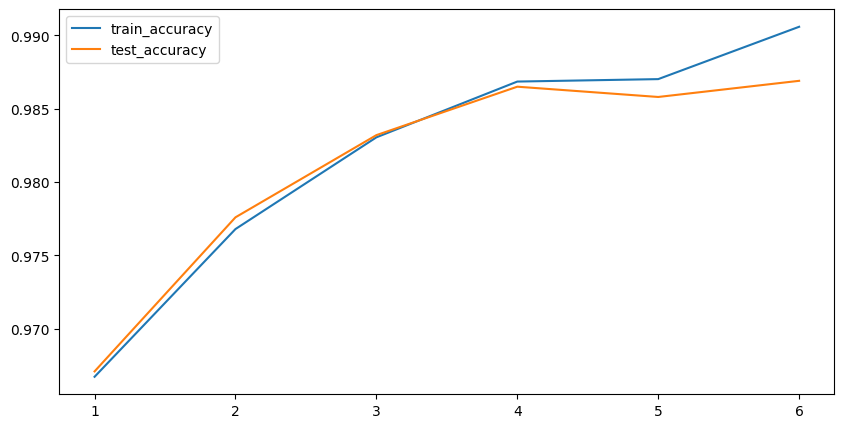

In [19]:
history_df = pd.DataFrame(history).T
history_df

plt.figure(figsize=(10, 5))
plt.plot(history_df.index, history_df['train_accuracy'], label='train_accuracy')
plt.plot(history_df.index, history_df['test_accuracy'], label='test_accuracy')
plt.legend()
print(f"5th epoch train accuracy: {history_df['train_accuracy'][5]}")
print(f"5th epoch test accuracy: {history_df['test_accuracy'][5]}")

We Got an Accuracy of 0.986 on 5th Epoch. Which is good but if observe the we can see that the graph has went down. 

We'll try adding Batch Normalization, This Objectively helps to improve the network.

#### Version 2

##### Batch Normalization
Here, We'll see how Batch Normalization Affected the Model Performance
Firstly we'll be using BN before Activation Function.

In [54]:
from torch import optim

cnn = CNN(
    batch_norm=True, 
    bn_ac=True,
    lrelu=False,
    ).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)      # optimizer.param_groups[0]['lr']

num_epochs = 6
history = train(
    num_epochs,
    cnn,
    train_dataloader,
    test_dataloader,
    loss_func,
    optimizer
)

Epoch 1/6  (

........................................) Epoch Time: 13.85s
    Train Loss: 0.0582, Train Accuracy: 0.9849
    Test Loss:  0.0569, Test Accuracy:  0.9837
Epoch 2/6  (........................................) Epoch Time: 13.77s
    Train Loss: 0.0398, Train Accuracy: 0.9890
    Test Loss:  0.0405, Test Accuracy:  0.9883
Epoch 3/6  (........................................) Epoch Time: 13.81s
    Train Loss: 0.0321, Train Accuracy: 0.9907
    Test Loss:  0.0378, Test Accuracy:  0.9877
Epoch 4/6  (........................................) Epoch Time: 13.85s
    Train Loss: 0.0288, Train Accuracy: 0.9911
    Test Loss:  0.0362, Test Accuracy:  0.9881
Epoch 5/6  (........................................) Epoch Time: 13.60s
    Train Loss: 0.0217, Train Accuracy: 0.9939
    Test Loss:  0.0284, Test Accuracy:  0.9913
Epoch 6/6  (........................................) Epoch Time: 13.63s
    Train Loss: 0.0167, Train Accuracy: 0.9951
    Test Loss:  0.0261, Test Accuracy:  0.9915


5th epoch train accuracy: 0.99385
5th epoch test accuracy: 0.9913


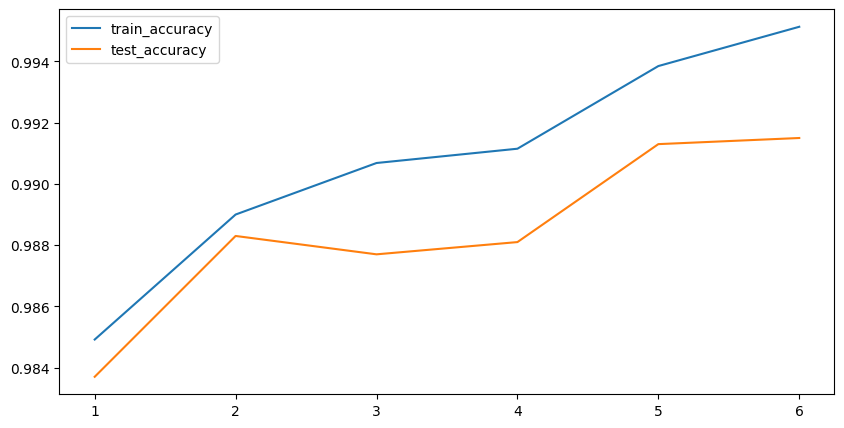

In [55]:
history_df = pd.DataFrame(history).T
history_df

plt.figure(figsize=(10, 5))
plt.plot(history_df.index, history_df['train_accuracy'], label='train_accuracy')
plt.plot(history_df.index, history_df['test_accuracy'], label='test_accuracy')
plt.legend()
print(f"5th epoch train accuracy: {history_df['train_accuracy'][5]}")
print(f"5th epoch test accuracy: {history_df['test_accuracy'][5]}")

The Performance here was improved significantly from `0.988` to `0.992`. This is a lot considering we only added Batch Normalization. 

##### Batch Normalization After Activation Function
Let's use the activation function first, then batch normalization. 

In [56]:
from torch import optim

cnn = CNN(
    batch_norm=True, 
    bn_ac=False,
    lrelu=False,
    ).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)      # optimizer.param_groups[0]['lr']

num_epochs = 6
history = train(
    num_epochs,
    cnn,
    train_dataloader,
    test_dataloader,
    loss_func,
    optimizer
)

Epoch 1/6  (

........................................) Epoch Time: 13.74s
    Train Loss: 0.0471, Train Accuracy: 0.9864
    Test Loss:  0.0453, Test Accuracy:  0.9866
Epoch 2/6  (........................................) Epoch Time: 14.20s
    Train Loss: 0.0352, Train Accuracy: 0.9894
    Test Loss:  0.0396, Test Accuracy:  0.9860
Epoch 3/6  (........................................) Epoch Time: 13.66s
    Train Loss: 0.0242, Train Accuracy: 0.9923
    Test Loss:  0.0304, Test Accuracy:  0.9892
Epoch 4/6  (........................................) Epoch Time: 13.87s
    Train Loss: 0.0234, Train Accuracy: 0.9926
    Test Loss:  0.0307, Test Accuracy:  0.9896
Epoch 5/6  (........................................) Epoch Time: 13.72s
    Train Loss: 0.0212, Train Accuracy: 0.9927
    Test Loss:  0.0297, Test Accuracy:  0.9894
Epoch 6/6  (........................................) Epoch Time: 13.72s
    Train Loss: 0.0158, Train Accuracy: 0.9950
    Test Loss:  0.0263, Test Accuracy:  0.9910


5th epoch train accuracy: 0.9927
5th epoch test accuracy: 0.9894


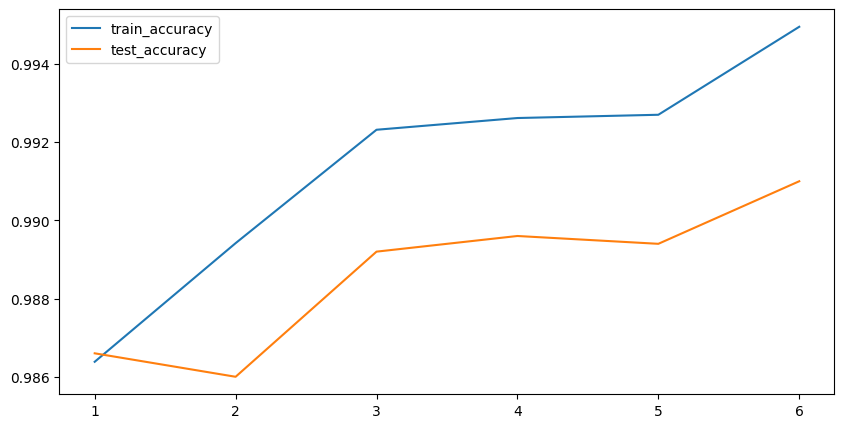

In [57]:
history_df = pd.DataFrame(history).T
history_df

plt.figure(figsize=(10, 5))
plt.plot(history_df.index, history_df['train_accuracy'], label='train_accuracy')
plt.plot(history_df.index, history_df['test_accuracy'], label='test_accuracy')
plt.legend()
print(f"5th epoch train accuracy: {history_df['train_accuracy'][5]}")
print(f"5th epoch test accuracy: {history_df['test_accuracy'][5]}")

The Performance hasn't changed much from the original version, The model has underperfomed compared to the last run. As we know, that in most of the implementations Batch Normalization is used before the ReLU activation this practically proves why.

There's an intutive explanation for this:

* As we know, after ReLU activation all the negative values are set to 0. By applying BN to those values we are basically setting them all to an identiacal non-zero values. The model may not be able to learn properly how to deal with those values.

* Contrary to this, if we apply BN before ReLU, We are going to have multiple zeros in the output, The model will learn quickly how to deal with those zeros.

##### Leaky ReLU
Relu function Just converts -ve values to 0. Although it works fine but we face a problem of dead neurons. Practically this is better than using Somthing like Sigmoid, but if we abstract some information from the -ve values then intution says that it will be better. So we use Leaky ReLU. 

Let's combine the above two combinations and see the results in one go.

In [58]:
from torch import optim

cnn_1 = CNN(
    batch_norm=True, 
    bn_ac=True,
    lrelu=True,
    ).to(device)
cnn_2 = CNN(
    batch_norm=True, 
    bn_ac=False,
    lrelu=True,
    ).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(cnn_1.parameters(), lr = 0.001)      # optimizer.param_groups[0]['lr']
optimizer_2 = optim.Adam(cnn_2.parameters(), lr = 0.001)      # optimizer.param_groups[0]['lr']

num_epochs = 6
history_1 = train(
    num_epochs,
    cnn_1,
    train_dataloader,
    test_dataloader,
    loss_func,
    optimizer_1
)


Epoch 1/6  (

........................................) Epoch Time: 14.34s
    Train Loss: 0.0714, Train Accuracy: 0.9812
    Test Loss:  0.0664, Test Accuracy:  0.9808
Epoch 2/6  (........................................) Epoch Time: 13.75s
    Train Loss: 0.0369, Train Accuracy: 0.9889
    Test Loss:  0.0369, Test Accuracy:  0.9886
Epoch 3/6  (........................................) Epoch Time: 13.76s
    Train Loss: 0.0316, Train Accuracy: 0.9901
    Test Loss:  0.0339, Test Accuracy:  0.9885
Epoch 4/6  (........................................) Epoch Time: 13.73s
    Train Loss: 0.0235, Train Accuracy: 0.9933
    Test Loss:  0.0316, Test Accuracy:  0.9901
Epoch 5/6  (........................................) Epoch Time: 13.87s
    Train Loss: 0.0209, Train Accuracy: 0.9940
    Test Loss:  0.0262, Test Accuracy:  0.9916
Epoch 6/6  (........................................) Epoch Time: 14.10s
    Train Loss: 0.0214, Train Accuracy: 0.9934
    Test Loss:  0.0286, Test Accuracy:  0.9907


In [59]:
history_2 = train(
    num_epochs,
    cnn_2,
    train_dataloader,
    test_dataloader,
    loss_func,
    optimizer_2
)

Epoch 1/6  (........................................) Epoch Time: 13.91s
    Train Loss: 0.0532, Train Accuracy: 0.9847
    Test Loss:  0.0506, Test Accuracy:  0.9851
Epoch 2/6  (........................................) Epoch Time: 13.63s
    Train Loss: 0.0380, Train Accuracy: 0.9884
    Test Loss:  0.0376, Test Accuracy:  0.9880
Epoch 3/6  (........................................) Epoch Time: 13.79s
    Train Loss: 0.0261, Train Accuracy: 0.9922
    Test Loss:  0.0330, Test Accuracy:  0.9899
Epoch 4/6  (........................................) Epoch Time: 13.88s
    Train Loss: 0.0263, Train Accuracy: 0.9910
    Test Loss:  0.0293, Test Accuracy:  0.9910
Epoch 5/6  (........................................) Epoch Time: 13.68s
    Train Loss: 0.0171, Train Accuracy: 0.9950
    Test Loss:  0.0306, Test Accuracy:  0.9902
Epoch 6/6  (........................................) Epoch Time: 13.68s
    Train Loss: 0.0182, Train Accuracy: 0.9943
    Test Loss:  0.0311, Test Accuracy:  0.989

5th epoch train accuracy: 0.9939833333333333
5th epoch test accuracy: 0.9916


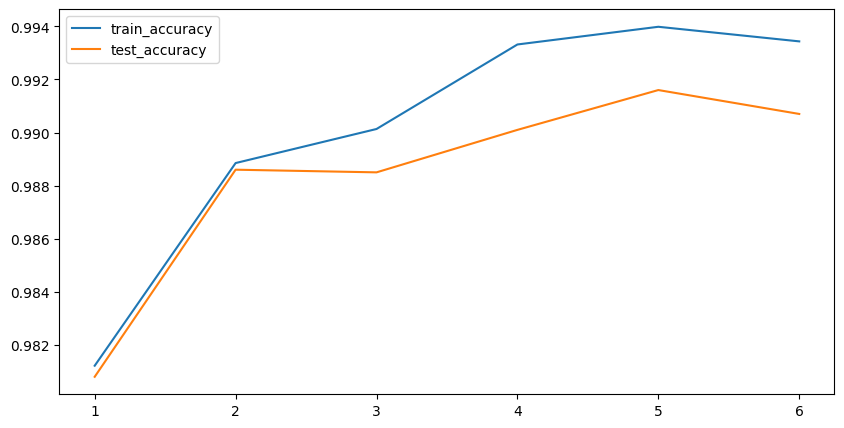

In [64]:
history_1_df = pd.DataFrame(history_1).T
history_2_df = pd.DataFrame(history_2).T

plt.figure(figsize=(10, 5))
plt.plot(history_df.index, history_1_df['train_accuracy'], label='train_accuracy')
plt.plot(history_df.index, history_1_df['test_accuracy'], label='test_accuracy')


# plt.plot(history_df.index, history_2_df['train_accuracy'], label='train_accuracy (ac->bn)')
# plt.plot(history_df.index, history_2_df['test_accuracy'], label='test_accuracy (ac->bn)')

print(f"5th epoch train accuracy: {history_1_df['train_accuracy'][5]}")
print(f"5th epoch test accuracy: {history_1_df['test_accuracy'][5]}")
# print(f"5th epoch train accuracy(ac->bn): {history_2_df['train_accuracy'][5]}")
# print(f"5th epoch test accuracy(ac->bn): {history_2_df['test_accuracy'][5]}")

plt.legend()

TBH, that wasn't a big difference. But still, the performance is better than the previous two models. So, I'll keep it.

In the graph we can observe that:
* The Training Accuracy hasn't changed much.
* The Losses have decreased quite a bit.
* The Validation Accuracy oscillated more. 


These Things can be happening randomly. But Still I believe we can Confortabely say that this this is happening because of learning rate.

Anyways, By seeing the above graphs, I'm going to stick with Leakly Relu and BN before activation.

#### Learning Rate Scheduler

By using a learning rate scheduler we can reduce the learning rate as we train the model. This will help us to get a better accuracy.


In [15]:
from torch import optim

cnn = CNN(
    batch_norm=True, 
    bn_ac=True,
    lrelu=True,
    ).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)      # optimizer.param_groups[0]['lr']
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma = 0.4)

num_epochs = 8
history = train(
    num_epochs,
    cnn,
    train_dataloader,
    test_dataloader,
    loss_func,
    optimizer,
    scheduler
)

Epoch 1/8  (........................................) Epoch Time: 13.92s
    Train Loss: 0.0550, Train Accuracy: 0.9832
    Test Loss:  0.0484, Test Accuracy:  0.9849
Epoch 2/8  (........................................) Epoch Time: 13.80s
    Train Loss: 0.0376, Train Accuracy: 0.9881
    Test Loss:  0.0430, Test Accuracy:  0.9850
Epoch 3/8  (........................................) Epoch Time: 13.80s
    Train Loss: 0.0192, Train Accuracy: 0.9941
    Test Loss:  0.0243, Test Accuracy:  0.9921
Epoch 4/8  (........................................) Epoch Time: 13.77s
    Train Loss: 0.0150, Train Accuracy: 0.9958
    Test Loss:  0.0195, Test Accuracy:  0.9936
Epoch 5/8  (........................................) Epoch Time: 13.78s
    Train Loss: 0.0134, Train Accuracy: 0.9966
    Test Loss:  0.0197, Test Accuracy:  0.9936
Epoch 6/8  (........................................) Epoch Time: 13.72s
    Train Loss: 0.0130, Train Accuracy: 0.9966
    Test Loss:  0.0192, Test Accuracy:  0.993

In [20]:
from torch import optim

cnn = CNN(
    batch_norm=True, 
    bn_ac=True,
    lrelu=True,
    ).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)      # optimizer.param_groups[0]['lr']
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma = 0.4)

num_epochs = 8
history = train(
    num_epochs,
    cnn,
    train_dataloader,
    test_dataloader,
    loss_func,
    optimizer,
    scheduler
)

Epoch 1/8  (........................................) Epoch Time: 13.81s
    Train Loss: 0.0539, Train Accuracy: 0.9827
    Test Loss:  0.0510, Test Accuracy:  0.9835
Epoch 2/8  (........................................) Epoch Time: 13.71s
    Train Loss: 0.0294, Train Accuracy: 0.9904
    Test Loss:  0.0287, Test Accuracy:  0.9905
Epoch 3/8  (........................................) Epoch Time: 13.94s
    Train Loss: 0.0176, Train Accuracy: 0.9948
    Test Loss:  0.0227, Test Accuracy:  0.9924
Epoch 4/8  (........................................) Epoch Time: 13.91s
    Train Loss: 0.0142, Train Accuracy: 0.9959
    Test Loss:  0.0219, Test Accuracy:  0.9925
Epoch 5/8  (........................................) Epoch Time: 13.80s
    Train Loss: 0.0131, Train Accuracy: 0.9965
    Test Loss:  0.0208, Test Accuracy:  0.9932
Epoch 6/8  (........................................) Epoch Time: 13.99s
    Train Loss: 0.0122, Train Accuracy: 0.9969
    Test Loss:  0.0208, Test Accuracy:  0.993

5th epoch train accuracy: 0.9965
5th epoch test accuracy: 0.9932


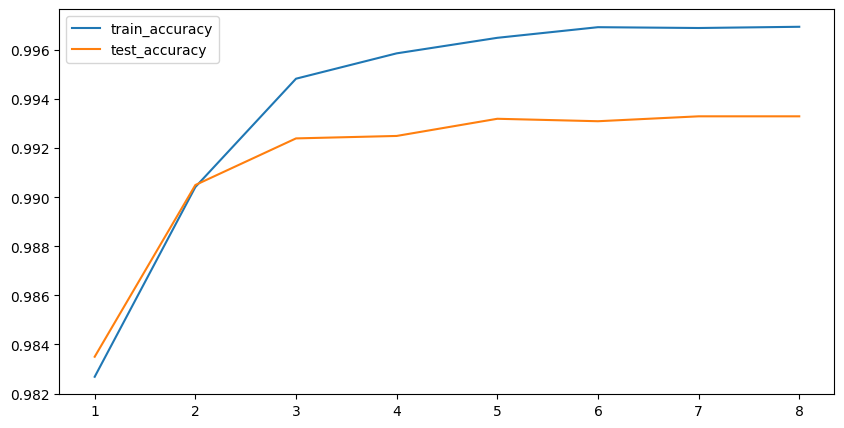

In [21]:
history_df = pd.DataFrame(history).T
history_df

plt.figure(figsize=(10, 5))
plt.plot(history_df.index, history_df['train_accuracy'], label='train_accuracy')
plt.plot(history_df.index, history_df['test_accuracy'], label='test_accuracy')
plt.legend()
print(f"5th epoch train accuracy: {history_df['train_accuracy'][5]}")
print(f"5th epoch test accuracy: {history_df['test_accuracy'][5]}")

So After using learning rate scheduler, The performance went up to `0.993` in 4 epochs. Seeing this I'm sure that the model can achieve `0.994` accuracy if I do `Grid Search`.

In [61]:
torch.save(cnn.state_dict(), model_path)

In [23]:
model = CNN()
model.load_state_dict(torch.load(model_path))
model.eval()

all_original = []
all_predicted = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images
        labels = labels
        output = model(images)[0]

        original = labels.tolist()
        predicted = torch.argmax(output, dim=1).tolist()

        all_original.extend(original)
        all_predicted.extend(predicted)
        
        

accuracy = accuracy_score(all_original, all_predicted)
f1_score_macro = f1_score(all_original, all_predicted, average='macro')
cm = confusion_matrix(all_original, all_predicted)
accuracy, f1_score_macro,

(0.9933, 0.9932587080572477)

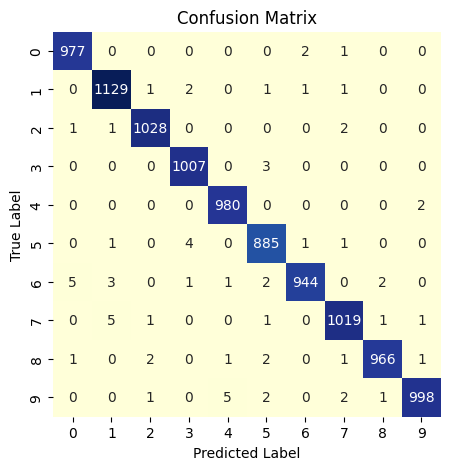

In [22]:
def confusion_matrix_plot(cm, figsize=(5, 5), labels=None):
    plt.figure(figsize=figsize)
    cm_plot = sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
    cm_plot.set_title('Confusion Matrix')
    cm_plot.set_xlabel('Predicted Label')
    cm_plot.set_ylabel('True Label')
    if labels:
        cm_plot.set_xticklabels(labels)
        cm_plot.set_yticklabels(labels)
    plt.show()
    
confusion_matrix_plot(cm)

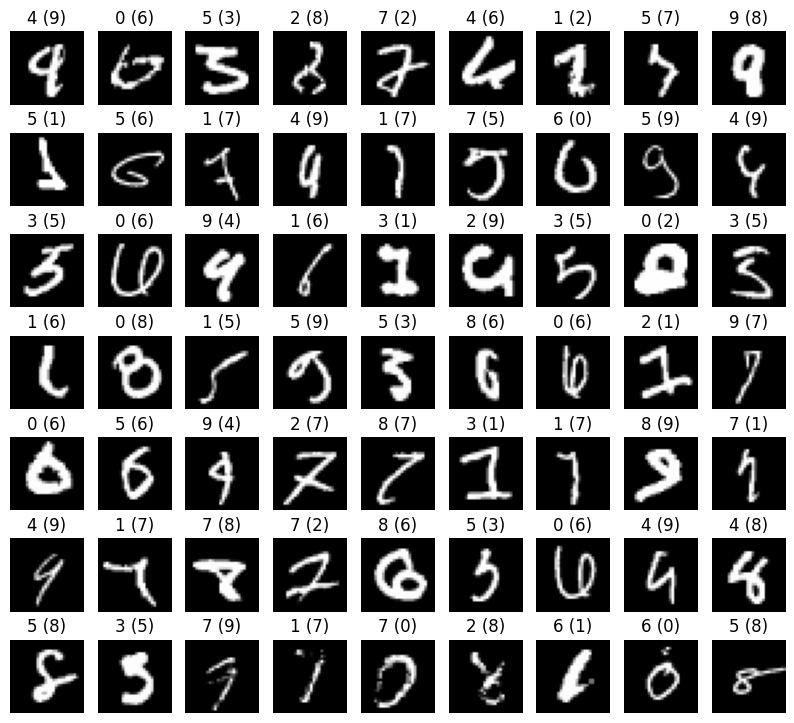

In [36]:
figure = plt.figure(figsize=(10, 9))
cols, rows = 9, 7
total = cols * rows

all_wrong = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images
        labels = labels
        output = model(images)[0]

        original = labels.tolist()
        predicted = torch.argmax(output, dim=1).tolist()

        for orig, pred, img in zip(original, predicted, images):
            if orig != pred: 
                all_wrong.append((orig, pred, np.array(img)))
        if len(all_wrong) >= total:
            break

for i in range(1, cols * rows + 1):
    label, pred, img = all_wrong[i - 1]
    figure.add_subplot(rows, cols, i)
    title = label
    if pred != label:
        title = f"{pred} ({title})"
        
    plt.title(title)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# Hyperparameter tuning: Grid search
# Let's try to find the best hyperparameters for our model. For Fun

# from torch import optim

# cnn = CNN(
#     batch_norm=True,
#     bn_ac=True,
#     lrelu=True,
#     ).to(device)

# lr_list = 0.015,  0.01, 0.0095, 0.009, 0.0085, 0.008, 0.0075
# gamma_list = 0.35, 0.4, 0.45,   0.5,   0.55,   0.6,   0.65

# loss_func = nn.CrossEntropyLoss()
# optimizer = optim.Adam(cnn.parameters(), lr = 0.0095)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma = 0.5)

# num_epochs = 6
# histories = []

# for lr in lr_list:
#     for gamma in gamma_list:
#         cnn_ = copy.deepcopy(cnn)
#         optimizer = optim.Adam(cnn_.parameters(), lr = lr)
#         scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma = gamma)
#         history = train(
#             num_epochs,
#             cnn_,
#             train_dataloader,
#             test_dataloader,
#             loss_func,
#             optimizer,
#             scheduler
#         )
#         histories.append({
#                 "history": history,
#                 "lr": lr,
#                 "gamma": gamma
#                 })

# histories

I sucessfully achieved the target of 99.5+% accuracy that too in 4 epochs by tryingout different learning rates and gamma values using gridsearch.
(see the logs of [this](https://www.kaggle.com/code/vineetmahajan/notebook0fbae1cc1f/log?scriptVersionId=138969343) notebook)

But I believe using `Gridsearch` defeats the purpose of this challenge😅. Where we have limited resourses to train the model. So Lets focus on making some changes in the network architecture.

Although is is good for understanding the effect of different hyperparameters on the model. And by learning from it I'll try to choose the better hyperparameters for the next model.

## Conclusion

By Applying various techniques I've achived a validation accuracy close to the target. Now I'm going to tryout different architectures in next Version.

I'll Combine the findings from this notebook too.